<a href="https://colab.research.google.com/github/ElaineSee/WOA7014_mini_project/blob/main/Mountain_Car.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Episode: 599, Best Score: 104, eps: 0.010

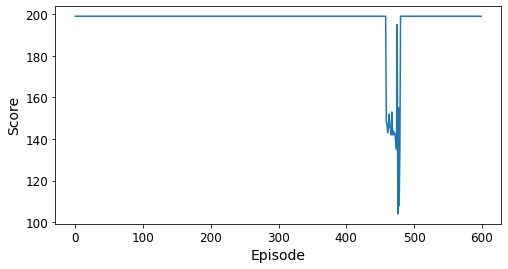

Wall time: 1h 52min 27s


In [ ]:
%%time
import gym
env = gym.make('MountainCar-v0')

#To see random steps & output
#observation = env.reset()
#print("observation:", observation)
#for t in range(5):
#    action = env.action_space.sample()
#    print("action:", action)
#    observation, reward, done, info = env.step(action)
#    print("step results:", observation, reward, done, info)
#env.close()
import numpy as np
import tensorflow as tf
from tensorflow import keras
from collections import deque

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

try:
    import pyvirtualdisplay
    display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
except ImportError:
    pass


class DQNagent:

    def __init__(self, state_size, action_size, episodes):
        self.gamma = 0.95
        self.batch_size = 10 #64
        self.state_size = state_size
        self.action_size = action_size
        self.episodes = episodes
        self.replay_memory = deque(maxlen=2000)
        self.optimizer = tf.keras.optimizers.Adam(lr=0.001) #use Adaptive Moment Estimation optimizer
        self.loss_fn = tf.keras.losses.mean_squared_error

    #Build neural network
    def build_model(self):
        model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(32, activation="relu", input_shape=[self.state_size]),
            tf.keras.layers.Dense(32, activation="relu"),
            tf.keras.layers.Dense(self.action_size)
        ])
        return model
    
    #Storing information about every step. ie replay memory
    def add_memory(self, state, action, reward, next_state, done):
        self.replay_memory.append((state, action, reward, next_state, done))
        
    #Implement training using memory replay from sampled experience, not full set
    def sample_experiences(self):
        indices = np.random.randint(len(self.replay_memory), size=self.batch_size)
        batch = [self.replay_memory[index] for index in indices]
        states, actions, rewards, next_states, dones = [
            np.array([experience[field_index] for experience in batch])
            for field_index in range(5)]
        return states, actions, rewards, next_states, dones
    
    
    def train_model(self, model):
        states, actions, rewards, next_states, dones = self.sample_experiences()
        next_Q_values = model.predict(next_states)
        max_next_Q_values = np.max(next_Q_values, axis=1)
        target_Q_values = (rewards + (1 - dones) * self.gamma * max_next_Q_values)
        target_Q_values = target_Q_values.reshape(-1, 1)
        mask = tf.one_hot(actions, self.action_size)
        with tf.GradientTape() as tape:
            all_Q_values = model(states)
            Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
            loss = tf.reduce_mean(self.loss_fn(target_Q_values, Q_values))
        grads = tape.gradient(loss, model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
def render_policy_net(model, n_max_steps=200, seed=42):
    frames = []
    env = gym.make('MountainCar-v0')
    env.seed(seed)
    np.random.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render(mode="rgb_array"))
        action = np.argmax(model.predict(obs[np.newaxis])[0])
        obs, reward, done, info = env.step(action)
        if done:
            break
    env.close()
    return frames

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

#frames = render_policy_net(model)
#plot_animation(frames)

best_score = 200
episodes = 600 #2000
env = gym.make('MountainCar-v0')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNagent(state_size, action_size, episodes)
model = agent.build_model()
rewards = []

for episode in range(episodes):
    state = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode/(episodes*0.8), 0.01) #epsilon take value between [0.1,1]
        if np.random.rand() < epsilon: action = np.random.randint(action_size) # if random no. < epsilon, take random sample
        else: action = np.argmax(model.predict(state[np.newaxis])[0]) # else take the best action
        next_state, reward, done, info = env.step(action)
        if next_state[0] - state[0] > 0 and action == 2: reward = 1 # if moved right & push right, reward +1
        if next_state[0] - state[0] < 0 and action == 0: reward = 1 # if moved left & push left, reward +1       
        agent.add_memory(state, action, reward, next_state, done)
        state = next_state.copy()
        if done:
            break
    rewards.append(step)
    if step < best_score:
        best_weights = model.get_weights()
        best_score = step
    
    print("\nEpisode: {}, Best Score: {}, eps: {:.3f}".format(episode, best_score, epsilon), end="") 
    
    if episode in np.arange(0, episodes, 50): #plot the animation every 50 episodes
        plot_animation(render_policy_net(model))
    
    if episode > 50:
        agent.train_model(model)

model.set_weights(best_weights)

env.close()

plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.show()

In [ ]:
plot_animation(render_policy_net(model))